In [1]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices: 
    tf.config.experimental.set_memory_growth(device, True)

In [2]:
import csv
import datetime
import matplotlib.pyplot as plt
from snippets import unpack_file, preprocess_timeseries
import numpy as np

from typing import Optional, Tuple, List

In [3]:
DATA_FILE = "climate-change-earth-surface-temperature-data.zip"
DIR = "climate"

unpack_file(DATA_FILE, DIR)

Files unzipped to /climate


In [4]:
DATA_FILE = DIR + "/GlobalLandTemperaturesByCity.csv"
CITY = "Zurich"

dates = []
temperatures = []

date_index = 0
temp_index = 1
city_index = 3

with open(DATA_FILE, "r") as file:

    reader = csv.reader(file, delimiter=",")
    next(reader)
    
    for row in reader:
        if row[city_index] == CITY:
            dates.append(row[date_index])
            temperatures.append(row[temp_index])
            
dates = [datetime.date.fromisoformat(date) for date in dates]
temperatures = [float(temp) if temp != "" else None for temp in temperatures]

In [5]:
def find_year_index(dates, start_year: int, end_year: Optional[int] = None) -> Tuple[int]:
    
    start = datetime.date(start_year, 1, 1)
    for start_index, date in enumerate(dates):
        if date == start:
            break
    
    if end_year:
        end = datetime.date(end_year, 1, 1)
        for end_index, date in enumerate(dates[start_index:]):
            if date == end:
                break

        end_index += start_index
    else:
        end_index = len(dates)
        
    return start_index, end_index


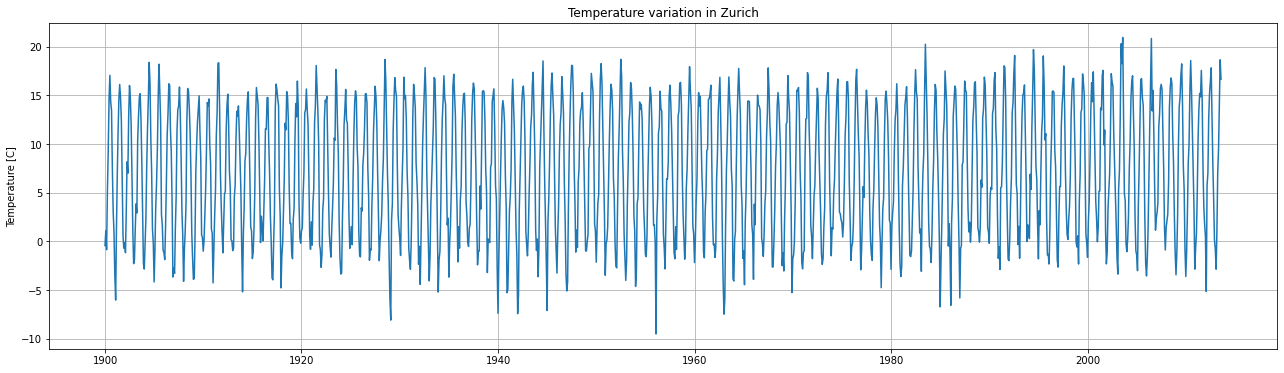

In [6]:
start, stop = find_year_index(dates, 1900)

plt.figure(figsize=(22,6))
plt.plot(dates[start:stop],temperatures[start:stop])
plt.title('Temperature variation in {}'.format(CITY))
plt.ylabel("Temperature [C]")
plt.grid(True)
plt.show()

In [7]:
# Data cleaning
def find_none(my_list: List) -> List[int]:
    
    where_none = []
    for i, element in enumerate(my_list):
        
        if element == None:
            where_none.append(i)
    return where_none

find_none(temperatures)

temperatures = temperatures[107:-1]
dates = dates[107:-1]

In [8]:
SPLIT_TIME = 2775

In [18]:
window_size = 24
batch_size = 2
shuffle_buffer = 50



train_data = temperatures[:SPLIT_TIME]
train_mean = sum(train_data)/len(train_data)
squared_diff = [(x - train_mean)**2 for x in train_data]
train_std = sum(squared_diff)/(len(train_data)-1)

normalized_data = [(x-mean)/std for x in temperatures]
input_data = preprocess_timeseries(normalized_data[:SPLIT_TIME], window_size, batch_size, shuffle_buffer)

In [23]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size = 5, padding="causal", activation="relu", input_shape=[None,1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 4))

model.compile(optimizer="adam", 
              metrics=["mae"], 
              loss=tf.keras.losses.Huber())
history = model.fit(input_data, epochs=10, callbacks = [lr_schedule])

Epoch 1/10
1376/1376 [==============================] - 11s 8ms/step - loss: 0.0108 - mae: 0.1295
Epoch 2/10
1376/1376 [==============================] - 11s 8ms/step - loss: 0.0101 - mae: 0.1250
Epoch 3/10
1376/1376 [==============================] - 9s 6ms/step - loss: 0.0084 - mae: 0.1131
Epoch 4/10
1376/1376 [==============================] - 11s 8ms/step - loss: 0.0049 - mae: 0.0798
Epoch 5/10
1376/1376 [==============================] - 11s 8ms/step - loss: 0.0033 - mae: 0.0590
Epoch 6/10
1376/1376 [==============================] - 12s 8ms/step - loss: 0.0027 - mae: 0.0534
Epoch 7/10
1376/1376 [==============================] - 11s 8ms/step - loss: 0.0021 - mae: 0.0464
Epoch 8/10
1376/1376 [==============================] - 11s 8ms/step - loss: 0.0015 - mae: 0.0410
Epoch 9/10
1376/1376 [==============================] - 11s 8ms/step - loss: 0.0013 - mae: 0.0378
Epoch 10/10
1376/1376 [==============================] - 11s 8ms/step - loss: 0.0011 - mae: 0.0354


(1e-06, 0.00015, -0.01, 0.02)

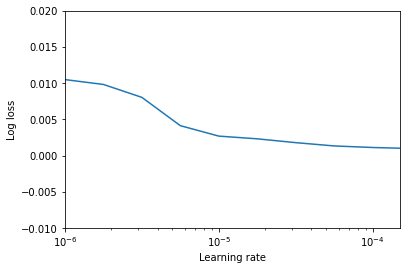

In [21]:
# Find optimal learning rate

plt.semilogx(history.history["lr"], history.history["loss"])
plt.ylabel("Log loss")
plt.xlabel("Learning rate")

plt.axis([1e-6, 1.5e-4, -0.01, 0.02])

In [11]:
# Re-run with optimal learning rate
OPTIMAL_LR = 1e-5
model.compile(optimizer=tf.keras.optimizers.Adam(lr=OPTIMAL_LR), 
              metrics=["mae"], 
              loss=tf.keras.losses.Huber())
history = model.fit(input_data, epochs=25)

Epoch 1/25
1376/1376 [==============================] - 13s 10ms/step - loss: 0.0068 - mae: 0.0972
Epoch 2/25
1376/1376 [==============================] - 13s 10ms/step - loss: 0.0034 - mae: 0.0604
Epoch 3/25
1376/1376 [==============================] - 13s 9ms/step - loss: 0.0030 - mae: 0.0558
Epoch 4/25
1376/1376 [==============================] - 11s 8ms/step - loss: 0.0026 - mae: 0.0517
Epoch 5/25
1376/1376 [==============================] - 11s 8ms/step - loss: 0.0022 - mae: 0.0480
Epoch 6/25
1376/1376 [==============================] - 13s 10ms/step - loss: 0.0019 - mae: 0.0451
Epoch 7/25
1376/1376 [==============================] - 11s 8ms/step - loss: 0.0017 - mae: 0.0432
Epoch 8/25
1376/1376 [==============================] - 11s 8ms/step - loss: 0.0016 - mae: 0.0420
Epoch 9/25
1376/1376 [==============================] - 11s 8ms/step - loss: 0.0015 - mae: 0.0408
Epoch 10/25
1376/1376 [==============================] - 12s 8ms/step - loss: 0.0015 - mae: 0.0400
Epoch 11/25
1376

In [19]:
# Forecasting

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

forecast = model_forecast(model, np.array(normalized_data)[..., np.newaxis], window_size)
forecast = forecast[SPLIT_TIME - window_size:-1, -1, 0]

In [21]:
# Accuracy metrics
mae = tf.keras.metrics.mean_absolute_error(forecast, normalized_data[SPLIT_TIME:]).numpy()
mse = tf.keras.metrics.mean_squared_error(forecast, normalized_data[SPLIT_TIME:]).numpy()

print("Mean absolute error: {}".format(mae))
print("Mean squared error: {}".format(mse))

Mean absolute error: 0.03453882783651352
Mean squared error: 0.0019075999734923244


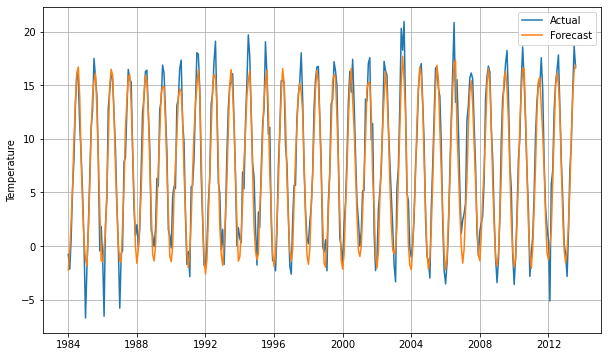

In [22]:
renormalized_forecast = [f*std + mean for f in forecast]

plt.figure(figsize=(10, 6))

plt.plot(dates[SPLIT_TIME:], temperatures[SPLIT_TIME:])
plt.plot(dates[SPLIT_TIME:], renormalized_forecast)
plt.ylabel("Temperature")
plt.legend(["Actual", "Forecast"])
plt.grid(True)
plt.show()